In [37]:
# Import necessary modules and functions

import pandas as pd # get information from files
import seaborn as sns # statistically summarizing information (for plots?)
import numpy as np # for large, multi-dimensional arrays and mathematical functions
import random

import matplotlib.pyplot as plt # a plotting library; (pyplot from python)
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

from scipy.stats import norm
from scipy import stats # scipy is a library for scientific computing; it imports statistical computation

# sklearn is a machine learning library:
from sklearn.preprocessing import StandardScaler # StandardScaler calculates z values
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [38]:
KS_trainSet = pd.read_csv('KS_train_data.csv', delimiter = ',') # gets training dataset
KS_testSet = pd.read_csv('KS_test_data.csv', delimiter = ',') # gets training dataset

training_data = pd.read_csv('training_data.csv', delimiter = ',') # gets training dataset

    The kickstarter website is basically a platform where people can scroll and find businesses
    that need some support to start. As a simple user, you can choose to donate money: 1 USD or more;
    I believe most people donate 1 USD. If business reaches its goal until the pre-set deadline,
    it will be funded. If not, no user will loose his/her dollar.
    
    Each project has the following attributes that describe it (the ones with a star are also in the test set)
    (the ! symbol is the final training set):

    !*project_id = unique identifier of project
    backers_count = how many people + institutions financially support the project
    *blurb = short description of project
    !*category = theme of project; can be art, music, publishing, crafts, ...
    !*subcategory = subfield of category
    *country = country where business shall take place
    *name = name of business
    !*staff_pick = TRUE if someone from the Kickstarter.com staff likes your project (doesn't rlly help with anything)
    !*location = city in which the business is located
    !funded = TRUE or FALSE 
    *project_url = website of business
    *reward_url = website where you can donate money for this business
    
    pledged = how many people donated
    usd_pledged = how much usd was donated (usually the same as pledged, bcz most people donate 1 usd)
    converted_pledged_amount = how much money was donated (sum is here converted)
    !*goal = the minimal sum they have to reach in order to be funded
    !*currency = the currency in which the money are represented
    !*fx_rate = currency exchange rate
    
    *created_at = time when project is put on website
    !*deadline = maximum time when project should be launched
    !*launched_at = when Kickstarters.com aprove it and it's the first day you cand start receiving money

In [39]:
################################################## CLEANING DATA ##############################################################

# Create another dataset with neccesary attributes:

# df = KS_trainSet[['project_id', 'category', 'subcategory', 'staff_pick', 'country', 'goal', 'currency', 'fx_rate', 'launched_at', 'deadline', 'funded']]
# export_csv = df.to_csv (r'C:\ComputerScience\Year3\Period1\IntroDataScience\IntroDataScienceKickstarter\training_data.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path

# There are quite a few instances that have an unknown country
# All of them use USD as currency. Therefore, we assume all these projects
# are from the US:

country_attribute = []
for i in range(len(training_data)):
    if(training_data.iloc[i].country != '?'):
        country_attribute.append(training_data.iloc[i].country)
    else:
        country_attribute.append('US')
        
training_data['final_country_attribute'] = country_attribute

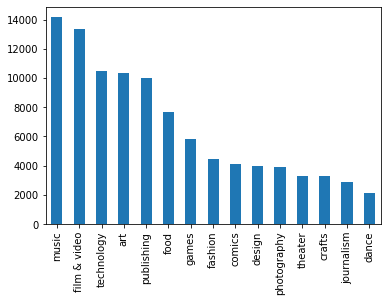

In [4]:
################################################### PICKING FEATURES ##########################################################

# 1. CATEGORY: 

training_data['category'].value_counts().plot(kind='bar')

In [ ]:
# This piece of code analyzes the 'category' attribute. 
# The printed vector shows the probability that, for each category, the project was picked to be funded

category_total_values = training_data['category'].value_counts()
categories = ['music', 'film & video', 'technology', 'art', 'publishing', 'food', 'games',
             'fashion', 'comics', 'design', 'photography', 'theater', 'crafts', 'journalism', 'dance']
print(categories)

category_funded = [0 for x in range(14)]

for i in range(14):
    counter = 0
    for index, row in training_data.iterrows():
        if ((row.category == categories[i]) and (row.funded == True)):
            counter += 1
    category_funded[i] = (int)((counter * 100) / category_total_values[i])
      
print(category_funded)

['music', 'film & video', 'technology', 'art', 'publishing', 'food', 'games', 'fashion', 'comics', 'design', 'photography', 'theater', 'crafts', 'journalism', 'dance']


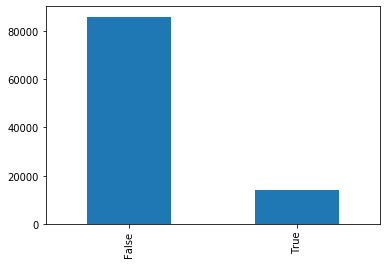

In [6]:
# 2. STAFF_PICK:

training_data['staff_pick'].value_counts().plot(kind='bar')

In [40]:
# This piece of code shows the probability of a project to be picked when it has staff_picks or not

staff_pick_total_values = training_data['staff_pick'].value_counts()
print(staff_pick_total_values)

staff_pick_funded = [0 for x in range(2)]
staff_pick_binary = []

true = 1
false = 0
counter = 0
counter2 = 0
for index, row in training_data.iterrows():
    if(row.staff_pick == True):
        staff_pick_binary.append(true)
    if(row.staff_pick == False):
        staff_pick_binary.append(false)
    if ((row.staff_pick == False) and (row.funded == True)):
        counter += 1
    if ((row.staff_pick == True) and (row.funded == True)):
        counter2 += 1
        
staff_pick_funded[0] = (int)((counter * 100) / staff_pick_total_values[0])
staff_pick_funded[1] = (int)((counter2 * 100) / staff_pick_total_values[1])
      
print(staff_pick_funded)

training_data['staff_pick_binary'] = staff_pick_binary

# Thus, 'staff_pick' can be used as a feature

False    86050
True     13950
Name: staff_pick, dtype: int64
[53, 89]


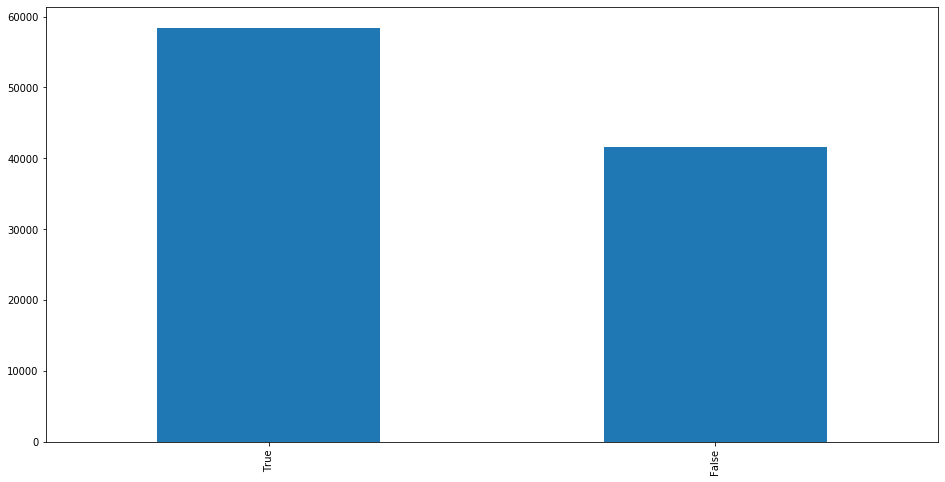

In [41]:
# 3. FUNDED:

training_data['funded'].value_counts().plot(kind='bar')

funded_binary = []

true = 1
false = 0
for index, row in training_data.iterrows():
    if(row.funded == True):
        funded_binary.append(true)
    if(row.funded == False):
        funded_binary.append(false)
        
training_data['funded_binary'] = funded_binary

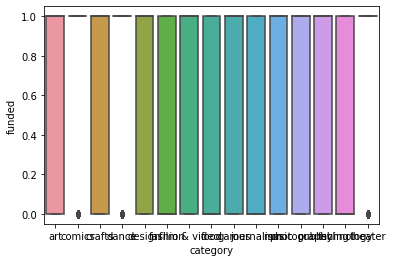

In [10]:
# sns.boxplot(x = training_data.category, y = training_data.funded)

In [42]:
################################################ MAKE YOUR OWN ATTRIBUTES ####################################################

# 4. DAYS_UNTIL_DEADLINE = DEADLINE - LAUNCHED_AT:

# calculates how many days a project has from launching to deadline

time_until_deadline = [0 for x in range(92)]
time_until_deadline_funded = [0 for x in range(92)]

# to add them in dataset:
to_be_added = []

for i in range(len(training_data)):
    aux = (int)((training_data.iloc[i].deadline - training_data.iloc[i].launched_at)/60/60/24)
    time_until_deadline[aux] += 1
    to_be_added.append(aux)
    if(training_data.iloc[i].funded == True):
        time_until_deadline_funded[aux] += 1
    
print(time_until_deadline)

[0, 47, 33, 74, 74, 135, 152, 512, 186, 216, 669, 226, 256, 363, 1406, 1446, 456, 441, 490, 516, 1976, 1972, 745, 697, 802, 1688, 716, 977, 1780, 5735, 40531, 2991, 1658, 1395, 1179, 2357, 815, 674, 527, 718, 2358, 453, 508, 422, 964, 3982, 481, 301, 257, 320, 624, 236, 209, 207, 196, 241, 204, 212, 305, 1957, 6226, 139, 54, 48, 27, 60, 52, 21, 26, 23, 54, 32, 31, 24, 19, 48, 18, 21, 16, 19, 35, 14, 18, 15, 23, 18, 33, 28, 62, 385, 322, 21]


In [56]:
# sees number of occurances of these days
# 1 day apare de 47 ori, 2 days apare de 33 ori, ...

print(time_until_deadline_funded)

[0, 21, 15, 38, 46, 85, 99, 331, 128, 162, 418, 177, 166, 252, 977, 875, 348, 303, 357, 351, 1266, 1473, 552, 530, 579, 1093, 500, 666, 1221, 3230, 21643, 2220, 1218, 995, 802, 1512, 593, 468, 347, 499, 1418, 305, 339, 283, 577, 2211, 351, 204, 167, 204, 322, 144, 118, 124, 110, 142, 115, 105, 156, 823, 2368, 116, 49, 42, 17, 54, 43, 17, 22, 19, 45, 28, 21, 20, 12, 41, 14, 18, 14, 15, 28, 11, 16, 9, 15, 13, 22, 21, 44, 278, 235, 13]


In [57]:
# in percentage:

for i in range(92):
    if (i != 0):
        time_until_deadline_funded[i] = (int)((time_until_deadline_funded[i] * 100) / time_until_deadline[i])
    
print(time_until_deadline_funded)

[0, 44, 45, 51, 62, 62, 65, 64, 68, 75, 62, 78, 64, 69, 69, 60, 76, 68, 72, 68, 64, 74, 74, 76, 72, 64, 69, 68, 68, 56, 53, 74, 73, 71, 68, 64, 72, 69, 65, 69, 60, 67, 66, 67, 59, 55, 72, 67, 64, 63, 51, 61, 56, 59, 56, 58, 56, 49, 51, 42, 38, 83, 90, 87, 62, 90, 82, 80, 84, 82, 83, 87, 67, 83, 63, 85, 77, 85, 87, 78, 80, 78, 88, 60, 65, 72, 66, 75, 70, 72, 72, 61]


In [43]:
training_data['days_until_deadline'] = to_be_added
# -------> THIS IS THE SHIT, creezi o noua coloana si egalezi cu o lista creata mai sus!

In [44]:
# 5. MONEY_PER_DAY_FUNDED

money_per_day = [0 for x in range(10)]
money_per_day_funded = [0 for x in range(10)]

money_each_day = []

for i in range(len(training_data)):
    aux = (int)((training_data.iloc[i].deadline - training_data.iloc[i].launched_at)/60/60/24)
    money = (int)(training_data.iloc[i].goal / aux)
    money_each_day.append(round(money))
    if(money < 10):
        money_per_day[0] += 1
        if(training_data.iloc[i].funded == True):
            money_per_day_funded[0] += 1
    if money in range(10, 25):
        money_per_day[1] += 1
        if(training_data.iloc[i].funded == True):
            money_per_day_funded[1] += 1
    if money in range(25, 50):
        money_per_day[2] += 1
        if(training_data.iloc[i].funded == True):
            money_per_day_funded[2] += 1
    if money in range(50, 100):
        money_per_day[3] += 1
        if(training_data.iloc[i].funded == True):
            money_per_day_funded[3] += 1
    if money in range(100, 250):
        money_per_day[4] += 1
        if(training_data.iloc[i].funded == True):
            money_per_day_funded[4] += 1
    if money in range(250, 500):
        money_per_day[5] += 1
        if(training_data.iloc[i].funded == True):
            money_per_day_funded[5] += 1
    if money in range(500, 1000):
        money_per_day[6] += 1
        if(training_data.iloc[i].funded == True):
            money_per_day_funded[6] += 1
    if money in range(1000, 5000):
        money_per_day[7] += 1
        if(training_data.iloc[i].funded == True):
            money_per_day_funded[7] += 1
    if money in range(5000, 10000):
        money_per_day[8] += 1
        if(training_data.iloc[i].funded == True):
            money_per_day_funded[8] += 1
    if(money not in range(0, 10000)):
        money_per_day[9] += 1
        if(training_data.iloc[i].funded == True):
            money_per_day_funded[9] += 1
        
print(money_per_day)
print(money_per_day_funded)

[4323, 8366, 10623, 15532, 25256, 14342, 10502, 9167, 1011, 878]
[2954, 5789, 7393, 10205, 15679, 8043, 4948, 3170, 190, 83]


In [32]:
# prediction money/day

for i in range(len(money_per_day)):
    money_per_day_funded[i] = (int)((money_per_day_funded[i] * 100) / money_per_day[i])
    
print(money_per_day_funded)

[68, 67, 70, 65, 61, 55, 48, 33, 18, 0]


In [45]:
# training_data['money_per_day'] = 0
training_data['money_per_day'] = money_each_day

print(training_data.money_per_day[0])

133


In [46]:
# category_dummy = pd.get_dummies(training_data.category)

# training_data['category_dummy'] = category_dummy

training_data = pd.get_dummies(training_data, columns = ['category'])

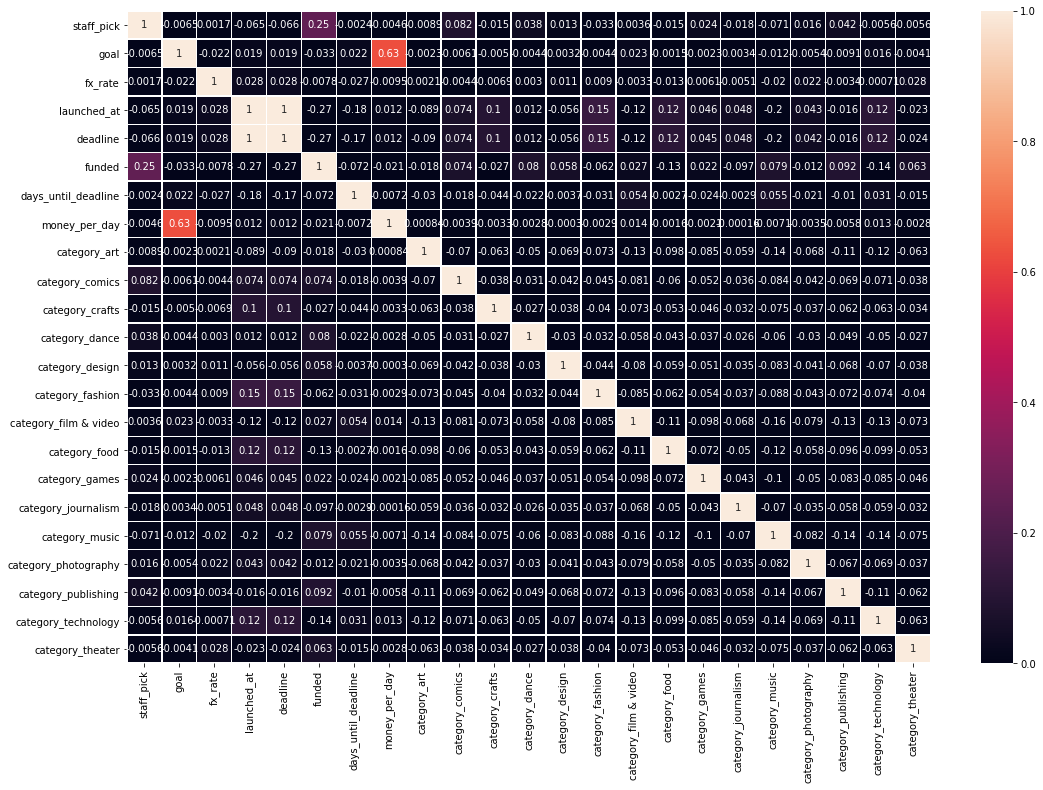

In [12]:
# Heatmaps are perfect for exploring the correlation of features in a dataset.

# First, get the correlation matrix:

correlation_matrix = training_data.corr()

# category_funded = training_data.pivot("category", "funded")

f,ax = plt.subplots(figsize=(18,12))
sns.heatmap(correlation_matrix, annot = True, linewidths = .5, ax = ax, vmin = 0, vmax = 1)

In [71]:
############## MY ATTEMPT INTO TRYING MULTIPLE LINEAR REGRESSION ############

X = pd.DataFrame(np.c_[training_data['staff_pick_binary'], training_data['days_until_deadline'], training_data['money_per_day']], columns = ['staff_pick_binary', 'days_until_deadline', 'money_per_day'])
Y = training_data['funded_binary']

In [72]:


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 9)

In [73]:
# create an instance of the model:

lin_reg_mod = LinearRegression()

# we fit the model on the training data:

lin_reg_mod.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [74]:
# make predictions:

pred = lin_reg_mod.predict(X_test)

# NOW, test predicted values in comparison with the actual values in the
# validation set by comparing two metric: RMSE and R-2

In [90]:
for i in range(len(pred)):
    if(pred[i] >= 0.5):
        pred[i] = 1
    else:
        pred[i] = 0
        
test_set_rmse = (np.sqrt(mean_squared_error(Y_test, pred)))
test_set_r2 = r2_score(Y_test, pred)

In [100]:
# Note that for rmse, the lower that value is, the better the fit
print(test_set_rmse)

# The closer towards 1, the better the fit
print(test_set_r2)

print('Variance score: %.2f' % lin_reg_mod.score(X_test, Y_test))
print("Mean squared error: %.2f" % np.mean((lin_reg_mod.predict(X_test) - Y_test) ** 2))

0.6310705190388789
-0.6418554615785985
Variance score: 0.07
Mean squared error: 0.23


In [97]:
count = 0
for i in range(len(Y_test)):
    if(Y_test.iloc[i] != pred[i]):
        count += 1
        
print(count)

7965
